In [9]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/ExcelData/train.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install niapy

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization


class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import time


hyperspectral_data = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
feature_names = df.columns[:-1].values

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X = hyperspectral_data
y = encoded_labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

problem = SVMFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=10, seed=1234)
best_features, best_fitness = algorithm.run(task)


In [13]:

selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:\n', feature_names[selected_features])
# print(len(feature_names[selected_features]))

start = time.perf_counter()

model_selected = SVC(kernel="linear")

model_selected.fit(X_train[:, selected_features], y_train)

end = time.perf_counter()

y_pred = model_selected.predict(X_test[:, selected_features])


Number of selected features: 70
Selected features:
 [888.71 898.38 903.22 912.9 917.74 927.42 932.26 937.11 941.96 946.81
 951.66 956.51 961.36 971.07 980.78 995.36 1019.69 1044.06 1048.93 1068.45
 1083.11 1092.88 1097.77 1117.35 1122.25 1127.14 1151.66 1166.38 1171.29
 1176.2 1181.11 1186.03 1205.7 1210.62 1245.11 1254.97 1264.85 1289.55
 1299.44 1309.33 1314.28 1339.05 1344.01 1348.97 1358.89 1363.85 1383.72
 1408.58 1413.56 1418.54 1423.52 1453.42 1463.4 1468.39 1498.37 1513.38
 1523.39 1528.4 1578.55 1598.65 1618.77 1623.8 1633.87 1638.91 1659.07
 1684.31 1689.36 1699.46 1709.57 1714.63]


In [14]:
print('Subset accuracy:', model_selected.score(X_test[:, selected_features], y_test))
print('Time taken:', end-start, 'sec')

Subset accuracy: 0.89568345323741
Time taken: 0.10871423799994773 sec


Confusion Matrix:


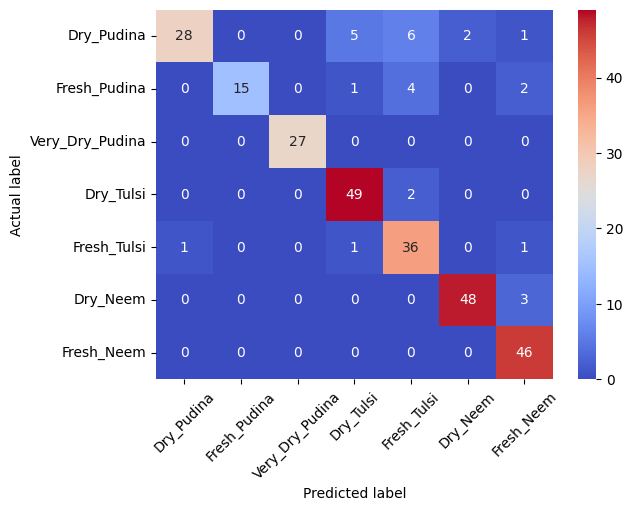

In [15]:
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)
lb = ['Dry_Pudina', 'Fresh_Pudina', 'Very_Dry_Pudina', 'Dry_Tulsi', 'Fresh_Tulsi', 'Dry_Neem', 'Fresh_Neem']
confusion_mat = confusion_matrix(y_test,y_pred, labels=lb)
print("Confusion Matrix:")
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=lb,
    yticklabels=lb,
)
plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()